In [1]:
"""
Logistic Regression - PyTorch Implementation
Using autograd for automatic gradient computation.
"""

import numpy as np
import json
import sys
sys.path.append('../..')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Self created utilities
from utils.metrics import accuracy, precision, recall, f1_score, auc_score
from utils.performance import track_performance
from utils.visualization import (
    plot_cost_curve,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importance
)

# Load preprocessed data (already scaled, SMOTE applied, 50/50 balanced)
X_train_np = np.load('../../data/processed/logistic_regression/X_train.npy')
X_test_np = np.load('../../data/processed/logistic_regression/X_test.npy')
y_train_np = np.load('../../data/processed/logistic_regression/y_train.npy')
y_test_np = np.load('../../data/processed/logistic_regression/y_test.npy')

# Load metadata for feature names
with open('../../data/processed/logistic_regression/preprocessing_info.json') as f:
    meta = json.load(f)
feature_names = meta['feature_names']

# NEW SECTION
# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test_np, dtype=torch.float32).reshape(-1, 1)

print(f"Training: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test: {X_test.shape[0]:,} samples")
print(f"Class balance - Train: {y_train.mean().item():.1%} fraud")
print(f"Class balance - Test: {y_test.mean().item():.1%} fraud")

Training: 454,902 samples, 30 features
Test: 56,962 samples
Class balance - Train: 50.0% fraud
Class balance - Test: 0.2% fraud


In [2]:
# Model Definition

# Single layer: 30 inputs ; 1 output
# PyTorch's nn.Linear handles weights and bias automatically
model = nn.Linear(in_features=30, out_features=1)

# BCEWithLogisticLoss combines sigmoid + BCE for numerical stability
# It applies sigmoid internally, so we don't need a separate activation
criterion = nn.BCEWithLogitsLoss()

# SGD optimizer - same as the manual gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.1) 

# Training loop

n_epochs = 1000
cost_history = []

with track_performance() as perf:
    for epoch in range(n_epochs):
        # Forward pass: compute logits (raw scores before sigmoid)
        logits = model(X_train) 

        # Compute loss (sigmoid applied internally by BCEWithLogitsLoss)
        loss = criterion(logits, y_train)
        cost_history.append(loss.item())

        # Backward pass: compute gradients automatically
        optimizer.zero_grad()   # Clear previous gradients
        loss.backward()         # Compute gradients via autograd
        optimizer.step()        # Update weights

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epcoh {epoch+1:4d} | Loss: {loss.item():.6f}")

print(f"\nTraining complete!")
print(f"Time: {perf['time']:.2f} sec | Memory: {perf['memory']:.2f} MB")


Epcoh  100 | Loss: 0.149933
Epcoh  200 | Loss: 0.101981
Epcoh  300 | Loss: 0.084414
Epcoh  400 | Loss: 0.075295
Epcoh  500 | Loss: 0.069664
Epcoh  600 | Loss: 0.065812
Epcoh  700 | Loss: 0.062994
Epcoh  800 | Loss: 0.060834
Epcoh  900 | Loss: 0.059119
Epcoh 1000 | Loss: 0.057721

Training complete!
Time: 2.36 sec | Memory: 0.05 MB


In [3]:
# Evaluation on Test Set

# Set model to evaluation mode (disable dropout, etc. - not used here but good practice for me)
model.eval()

# Get predictions (no gradient tracking need for inference)
with torch.no_grad():
    logits_test = model(X_test)
    y_proba_tensor = torch.sigmoid(logits_test)     # Convert logits to probabilities

# Convert to NumPy for our metrics functions
y_proba = y_proba_tensor.numpy().flatten()
y_pred = (y_proba >= 0.5).astype(int)
y_test_np = y_test.numpy().flatten()

# Calculate metrics using the shared utilities
acc = accuracy(y_test_np, y_pred)
prec = precision(y_test_np, y_pred)
rec = recall(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
auc = auc_score(y_test_np, y_pred)

# Print results
print("=" * 40)
print("TEST SET RESULTS")
print("=" * 40)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

TEST SET RESULTS
Accuracy:  0.9890
Precision: 0.1169
Recall:    0.8265
F1 Score:  0.2048
AUC-ROC:   0.9034


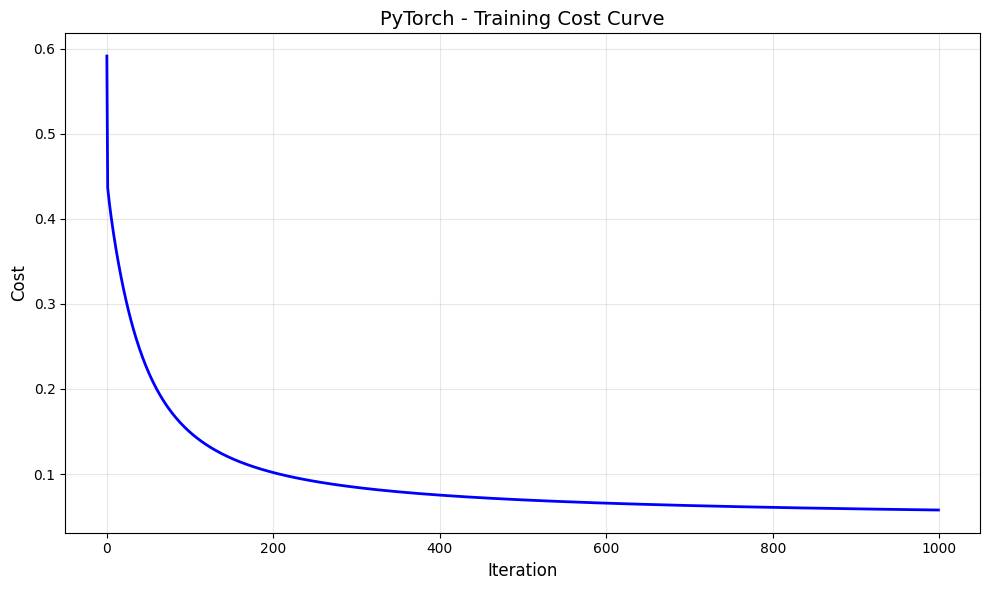

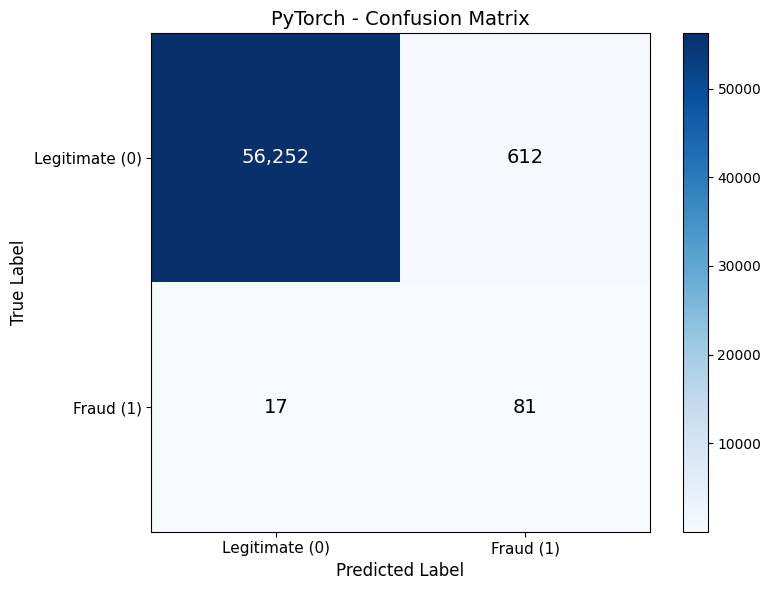

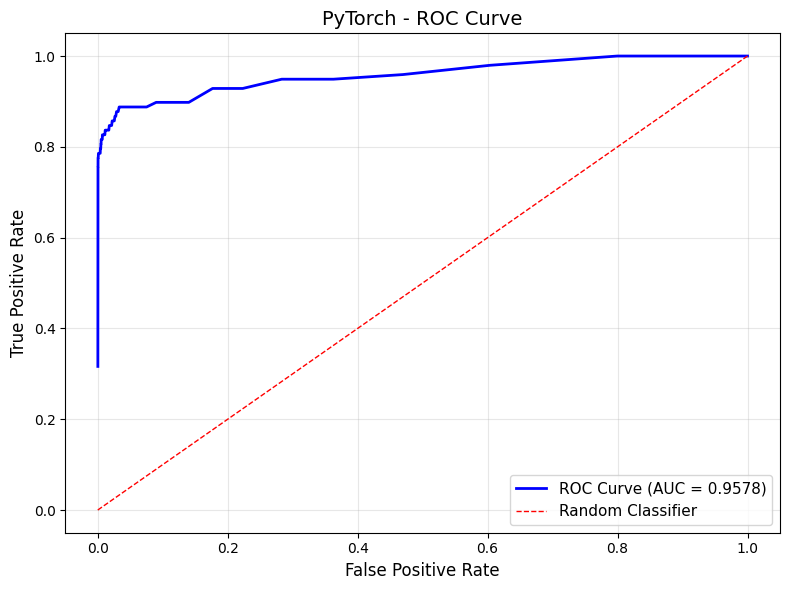

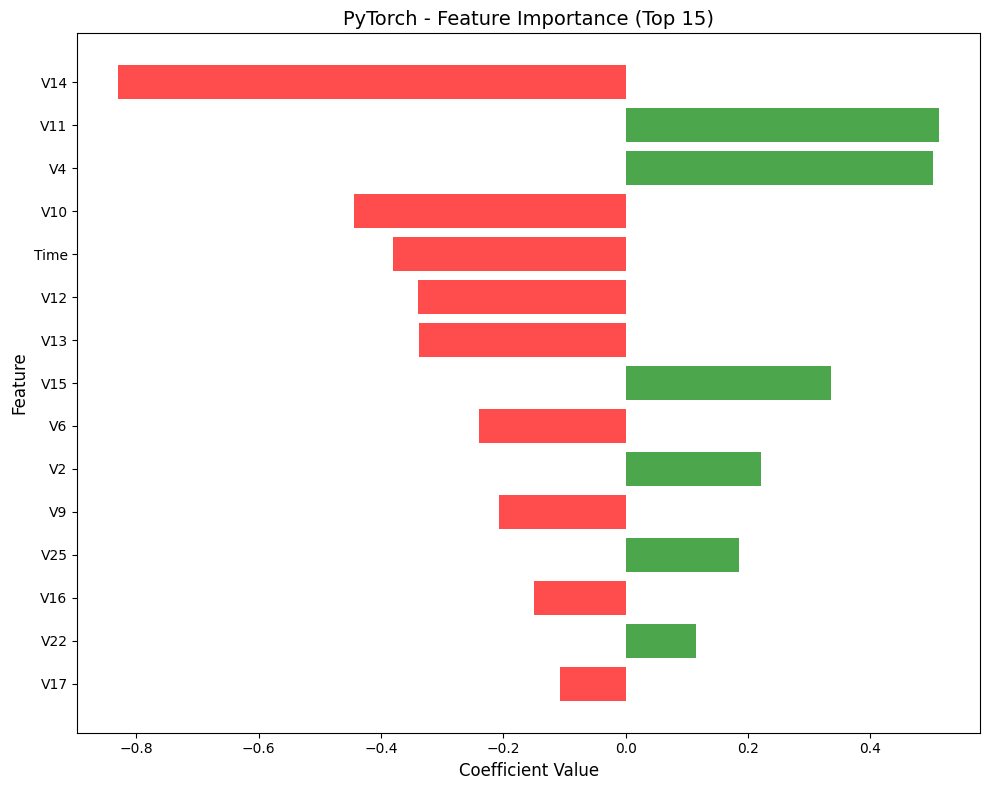

In [4]:
# Visualizations

# Cost curve
plot_cost_curve(
    cost_history,
    framework="PyTorch",
    save_path="results/cost_curve.png"
)

# Confusion matrix
plot_confusion_matrix(
    y_test_np, y_pred,
    framework="PyTorch",
    save_path="results/confusion_matrix.png"
)

# ROC curve
plot_roc_curve(
    y_test_np, y_proba,
    framework="PyTorch",
    save_path="results/roc_curve.png"
)

# Feature importance (extract weights from PyTorch model)
weights = model.weight.detach().numpy().flatten()
plot_feature_importance(
    weights, feature_names,
    framework="PyTorch",
    save_path="results/feature_importance.png"
)

In [5]:
# Final Summary


print("=" * 50)
print("PYTORCH LOGISTIC REGRESSION - SUMMARY")
print("=" * 50)

print(f"\nModel Configuration:")
print(f"  Architecture: nn.Linear(30, 1)")
print(f"  Loss: BCEWithLogitsLoss")
print(f"  Optimizer: SGD (lr=0.1)")
print(f"  Epochs: {n_epochs}")

print(f"\nPerformance:")
print(f"  Training Time: {perf['time']:.2f} sec")
print(f"  Peak Memory: {perf['memory']:.2f} MB")

print(f"\nTest Metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  AUC-ROC:   {auc:.4f}")

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  56,252")
print(f"  False Positives: 612")
print(f"  False Negatives: 17")
print(f"  True Positives:  81")

print(f"\nComparison:")
print(f"  vs No-Framework: {18.34 / perf['time']:.1f}x faster (autograd vs manual)")
print(f"  vs Scikit-Learn: {perf['time'] / 0.32:.1f}x slower (SGD vs L-BFGS)")


PYTORCH LOGISTIC REGRESSION - SUMMARY

Model Configuration:
  Architecture: nn.Linear(30, 1)
  Loss: BCEWithLogitsLoss
  Optimizer: SGD (lr=0.1)
  Epochs: 1000

Performance:
  Training Time: 2.36 sec
  Peak Memory: 0.05 MB

Test Metrics:
  Accuracy:  0.9890
  Precision: 0.1169
  Recall:    0.8265
  F1 Score:  0.2048
  AUC-ROC:   0.9034

Confusion Matrix:
  True Negatives:  56,252
  False Positives: 612
  False Negatives: 17
  True Positives:  81

Comparison:
  vs No-Framework: 7.8x faster (autograd vs manual)
  vs Scikit-Learn: 7.4x slower (SGD vs L-BFGS)
